In [66]:
!python --version

Python 3.8.0


# Package to install
!pip install rasterio  
!pip install rioxarray  
!pip install geopandas  
!pip install earthpy  

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rasterio
import rioxarray as rxr
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from matplotlib.colors import ListedColormap

### Functions

In [28]:
# NDVI Calculation

def ndvi(file):
    
    # read the both .tiff files for red(B04) & nir (B08)
    red_file = rxr.open_rasterio(img_path+'/'+red)
    nir_file = rxr.open_rasterio(img_path+'/'+nir)
    
    # calculate the NDVI
    ndvi = es.normalized_diff(file[0], file[3])
    
    # plot the results
    ep.plot_bands(ndvi,
              cmap='PiYG',
              scale=False,
              vmin=-1, vmax=1,
              title="Sentinel2 L2C Derived NDVI")
    plt.show()
    
    return ndvi

# Vegetation classification

def veg_class(ndvi,save_path,file):
    
    # Create classes and apply to NDVI results
    ndvi_class_bins = [-np.inf, 0.6, np.inf]
    ndvi_landsat_class = np.digitize(ndvi, ndvi_class_bins)

    # Apply the nodata mask to the newly classified NDVI data
    ndvi_landsat_class = np.ma.masked_where(np.ma.getmask(ndvi), 
                                            ndvi_landsat_class)
    #np.unique(ndvi_landsat_class)
    
    # Define color map
    nbr_colors = ["gray", "g"]
    nbr_cmap = ListedColormap(nbr_colors)

    # Define class names
    ndvi_cat_names = [
        "No Vegetation",
        "Vegetation"]

    # Get list of classes
    classes = np.unique(ndvi_landsat_class)
    classes = classes.tolist()
    
    # The mask returns a value of none in the classes. remove that
    classes = classes[0:2]

    # Plot your data
    fig, ax = plt.subplots()
    im = ax.imshow(ndvi_landsat_class, cmap=nbr_cmap)
    ax.set_axis_off()
    canvas = plt.gca().figure.canvas
    canvas.draw()
    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    image = data.reshape(canvas.get_width_height()[::-1] + (3,))
    
    #save img
    veg_file = os.path.splitext(file)[0]+'_g'+'.png'
    plt.savefig(save_path+'/'+veg_file)
    print(veg_file+'\n'+"successfully saved!")

    return veg_file

# read img

def read_img(path,file):
    img = cv2.imread(path+'/'+file)
    plt.imshow(img)
    plt.show()
    return img
    
# to count the number of pixels indite the polygon

def polygon_pixel(image):
    
    '''
    image: Vegetation classified image
    return: total pixel of the polygon image
    '''
    gray_Img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # Find Canny edges
    edged = cv2.Canny(gray_Img, 30, 200)
  
    # Finding Contours
    # since findContours alters the image - making a copy
    edged_copy = edged.copy()
    contours, hierarchy = cv2.findContours(edged_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Going through every contours found in the image.
    for cnt in contours :

        approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)

        # Used to flatted the array containing the co-ordinates of the vertices.
        n = approx.ravel()
        vertices = []
        i = 0
        for j in n :
            if(i % 2 == 0):
                coord=[]
                x = n[i]
                y = n[i + 1]
                coord = [x,y]

                # String containing the co-ordinates.
                string = list(coord)
                vertices.append(string)

            i = i + 1

    # define polygon points
    points = np.array([vertices],  dtype=np.int32)

    # create mask for polygon
    mask_polygon = np.zeros_like(gray_Img)
    mask_polygon = cv2.fillPoly(mask_polygon,[points],(255))

    # counting the number of pixels
    total_white_pix = np.sum(mask_polygon == 255)
    total_black_pix = np.sum(mask_polygon == 0)

    #print('Number of white pixels (inside polygon):', total_white_pix)
    #print('Number of black pixels (outside polygon):', total_black_pix)       
    #plt.imshow(mask_polygon)
    #plt.show()
    
    return total_white_pix
    
# to count the total green pixel of the hsv image

def green_pixel(image):
    
    '''
    image: Vegetation classified image
    return: total green pixel of the hsv image
    '''
    hsv_Img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    light_green = (50, 100, 100)
    dark_green = (70, 255, 255)
    
    mask_green = cv2.inRange(hsv_Img, light_green, dark_green)
    
    white_pix = np.sum(mask_green == 255)
    black_pix = np.sum(mask_green == 0)
    
    #print('Number of white pixels (green area only):', white_pix)
    #print('Number of black pixels (non green + outside polygon):', black_pix)
    plt.imshow(mask_green)
    plt.show()
    
    return white_pix

# forest cover calculation

def forest_cover(polygon_pixel, green_pixel):
    '''
    polygon_pixel: total number of pixel insite the polygon image
    green_pixel: total number of green pixel in the hsv image
    '''
    forest_cover = (green_pixel/polygon_pixel)*100
    print("Forest Cover as a % of total area = " + str(forest_cover) + "%")

## Test1 - SL_Sinharaja

In [3]:
img_path = './Data/Test/SL_Sinharaja'
true_file = '2022-08-15-00_00_2022-08-15-23_59_Sentinel-2_L2A_True_color.tiff'
red_file = '2022-08-15-00_00_2022-08-15-23_59_Sentinel-2_L2A_B04_(Raw).tiff'
nir_file = '2022-08-15-00_00_2022-08-15-23_59_Sentinel-2_L2A_B08_(Raw).tiff'

In [4]:
# Show true color img

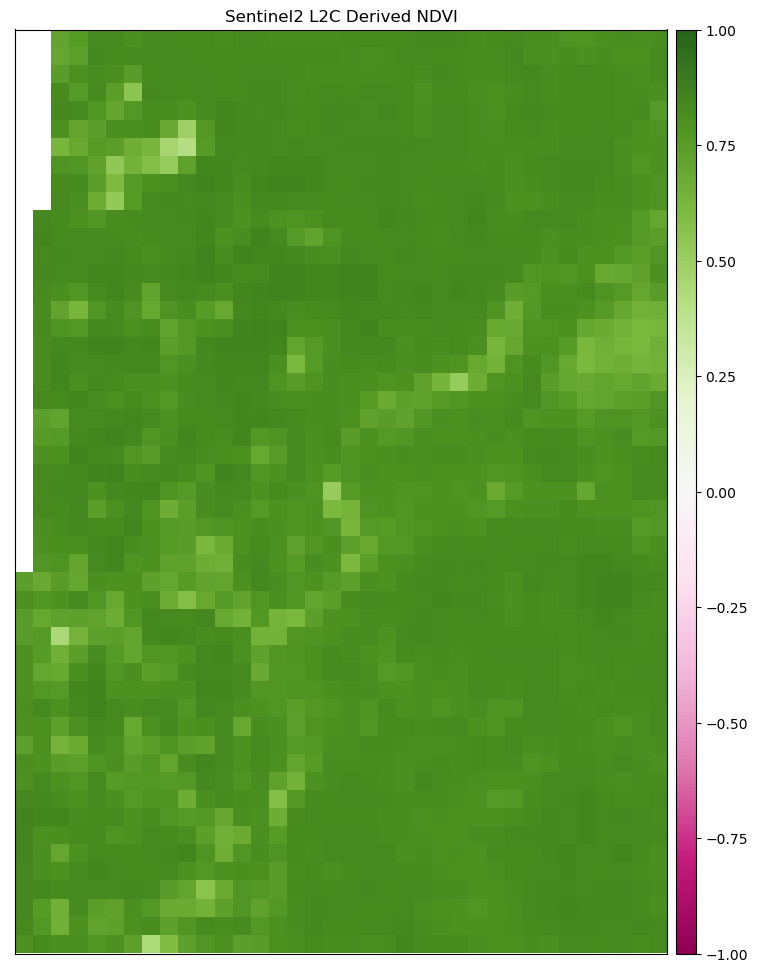

2022-08-15-00_00_2022-08-15-23_59_Sentinel-2_L2A_True_color_g.png
successfully saved!


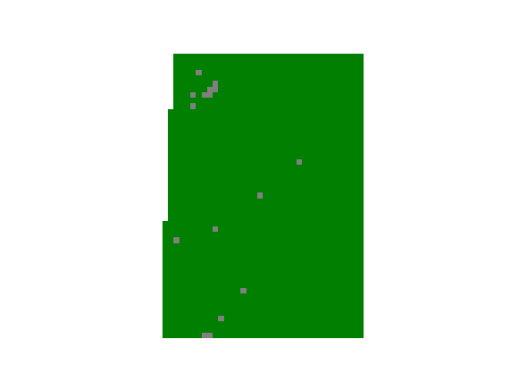

Number of green pixels: 93445


In [5]:
ndvi = ndvi(red_file,nir_file)
veg_file = veg_class(ndvi,img_path,true_file)
img = read_img(img_path,veg_file)
green = pixel_count(img)
print('Number of green pixels:', green)

## SL_Colombo

In [6]:
img_path = './Data/Test/SL_Colombo'
true_file = '2022-09-22-00_00_2022-09-22-23_59_Sentinel-2_L2A_True_color.tiff'
red_file = '2022-09-22-00_00_2022-09-22-23_59_Sentinel-2_L2A_B04_(Raw).tiff'
nir_file = '2022-09-22-00_00_2022-09-22-23_59_Sentinel-2_L2A_B08_(Raw).tiff'

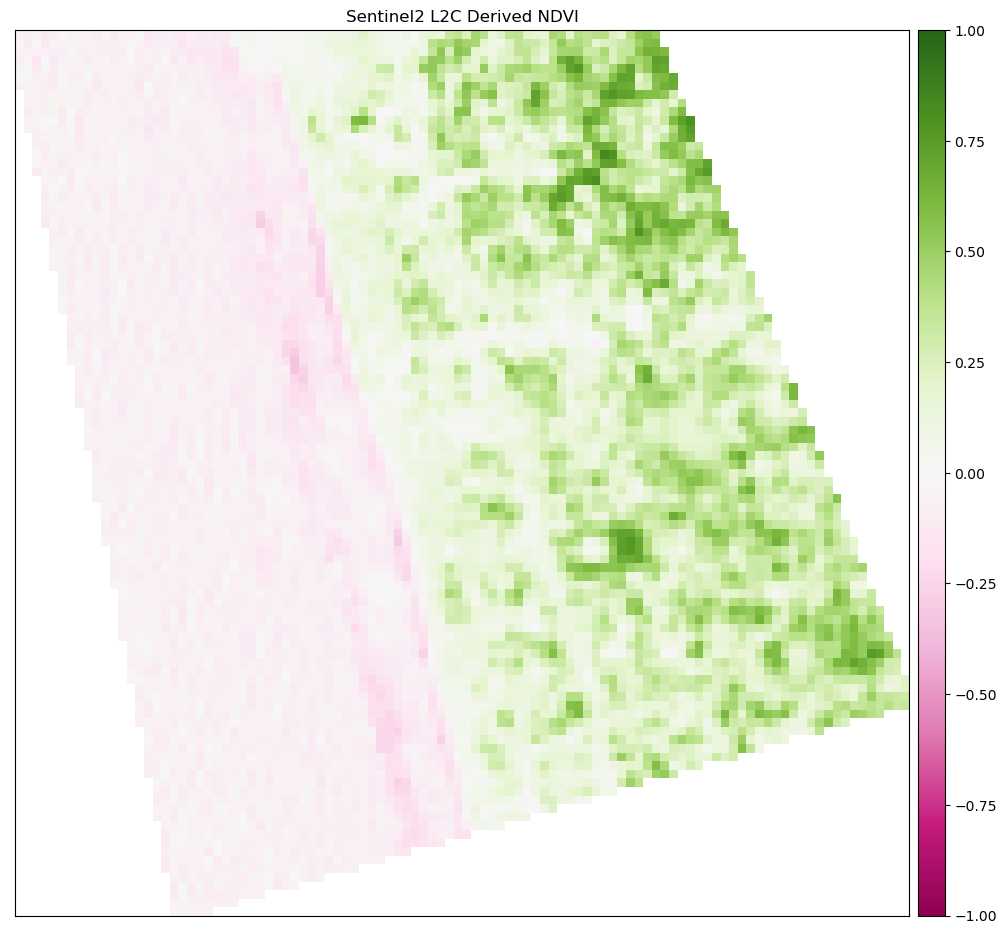

2022-09-22-00_00_2022-09-22-23_59_Sentinel-2_L2A_True_color_g.png
successfully saved!


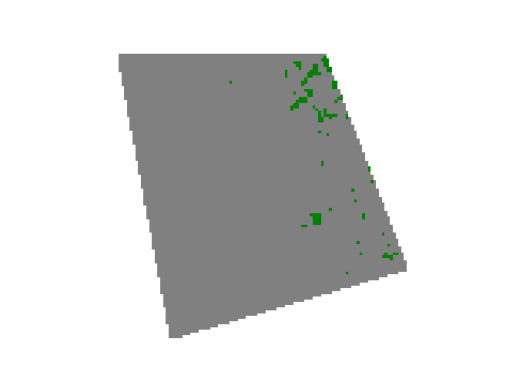

Number of green pixels: 1666


In [9]:
ndvi = ndvi(red_file,nir_file)
veg_file = veg_class(ndvi,img_path,true_file)
img = read_img(img_path,veg_file)
green = pixel_count(img)
print('Number of green pixels:', green)

In [27]:
# Show a tiff img
img_path = r'C:\Users\User\OneDrive - Engenuity (Pvt) Ltd\Github\SPE-testing\Sentinel-hub API\Data\1c5f37a5e439d3efdf4c08bc848a9449'
file = 'response.tiff'

In [ ]:
ndvi = ndvi(file)
veg_file = veg_class(ndvi,img_path,true_file)
img = read_img(img_path,veg_file)
green = pixel_count(img)
print('Number of green pixels:', green)

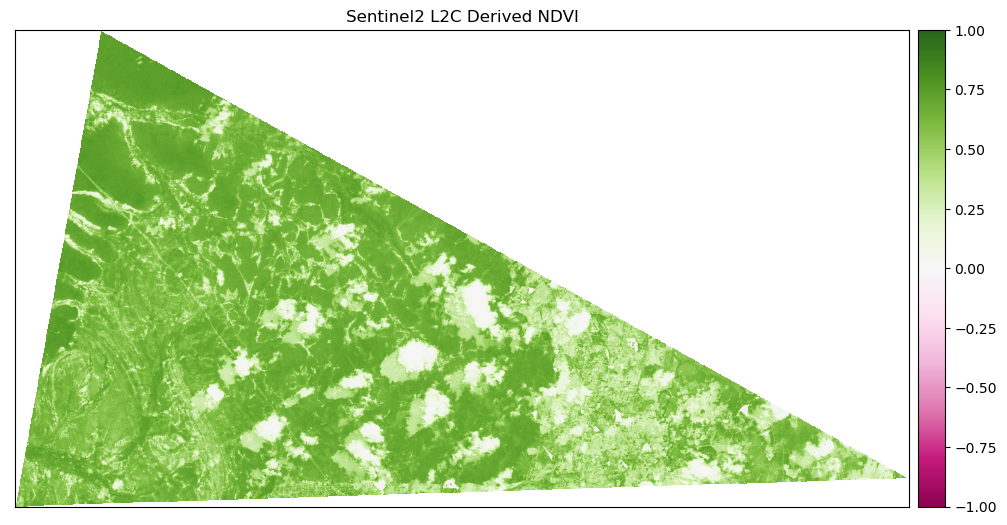

In [23]:
ndvi = es.normalized_diff(file[0], file[3])
    
# plot the results
ep.plot_bands(ndvi,
          cmap='PiYG',
          scale=False,
          vmin=-1, vmax=1,
          title="Sentinel2 L2C Derived NDVI")
plt.show()

In [ ]:
veg_file = veg_class(ndvi,img_path,true_file)
img = read_img(img_path,veg_file)
total_pix = polygon_pixel(img)
green_pix = green_pixel(img)
forest_cover(total_pix,green_pix)